## Importing libraries

In [20]:
# Dataframe and Plotting libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingClassifier,RandomForestClassifier
# Machine Learning libraries
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GroupKFold,StratifiedKFold

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder


pd.set_option('display.max_columns', None)
# from google.colab import files
import warnings
warnings.filterwarnings('ignore')

## 1. Load the dataset

In [55]:
# Load the files into a Pandas Dataframe
train = pd.read_csv('Train.csv')
test = pd.read_csv('Test.csv')
ss = pd.read_csv('SampleSubmission.csv')
extra=pd.read_csv('extra_data.csv')
train

,MERCHANT_CATEGORIZED_AT,MERCHANT_NAME,MERCHANT_CATEGORIZED_AS,PURCHASE_VALUE,PURCHASED_AT,IS_PURCHASE_PAID_VIA_MPESA_SEND_MONEY,USER_AGE,USER_GENDER,USER_HOUSEHOLD,USER_INCOME,USER_ID,Transaction_ID
0,2022-05-04 10:25:50.588042+00,UONSDA CHURCH MOGERE MWAYO TITHE,Rent / Mortgage,1700,2022-05-04 13:56:00+00,False,NaN,Male,3,10000,ID_ZX4DCF4K,ID_04mk78fa
1,2021-10-25 16:18:38.586837+00,PARK N GO,Transport & Fuel,100,2021-10-24 14:12:00+00,False,25.0,Female,4,90000,ID_U9WZMGJZ,ID_04xkfb07
2,2022-05-20 14:17:30.917297+00,SAFARICOM OFFERS TUNUKIWA,Data & WiFi,20,2022-05-27 12:46:00+00,False,NaN,Male,3,10000,ID_ZX4DCF4K,ID_051urwuw
3,2022-04-12 15:59:14.139347+00,ZILLIONS CREDIT LIMITED,Loan Repayment,3800,2022-02-07 12:16:00+00,False,NaN,Male,5,252000,ID_3JA0MAFB,ID_0e1om7rz
4,2022-05-04 10:24:26.709045+00,MICHAEL MUSEMBI,Bills & Fees,60,2022-05-04 15:28:00+00,False,NaN,Male,3,10000,ID_ZX4DCF4K,ID_0kfcoawb
...,...,...,...,...,...,...,...,...,...,...,...,...
368,2021-08-06 11:28:03.723042+00,ONESMUS GAKURU,Miscellaneous,500,2021-08-26 13:38:00+00,True,27.0,Female,2,8000,ID_L8QMYB09,ID_zr5x8yjs
369,2022-04-12 15:57:05.758311+00,GLADWELL MBURU,Miscellaneous,400,2022-04-03 08:39:00+00,True,NaN,Male,5,750000,ID_D8FOVVBB,ID_zty81sq8
370,2021-12-01 08:33:13.82067+00,SAFARICOM LIMITED,Data & WiFi,500,2021-01-15 15:40:00+00,False,NaN,Male,3,200000,ID_ECX9BS4A,ID_zx5ajeqe
371,2021-10-05 12:29:13.14963+00,EQUITY PAYBILL ACCOUNT,Bills & Fees,14000,2021-10-08 10:33:00+00,True,25.0,Female,4,90000,ID_U9WZMGJZ,ID_zx9hnvvb


## 2. Understand the dataset

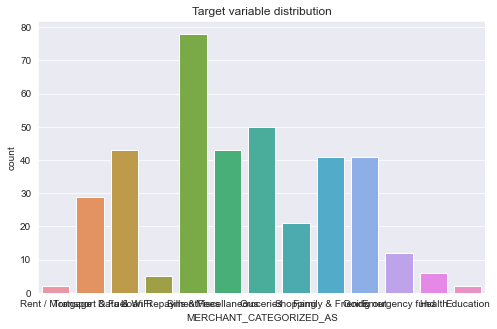

In [322]:
# Target variable distribution
sns.set_style('darkgrid')
plt.figure(figsize=(8, 5))
sns.countplot(train["MERCHANT_CATEGORIZED_AS"])
plt.title('Target variable distribution')
plt.show()

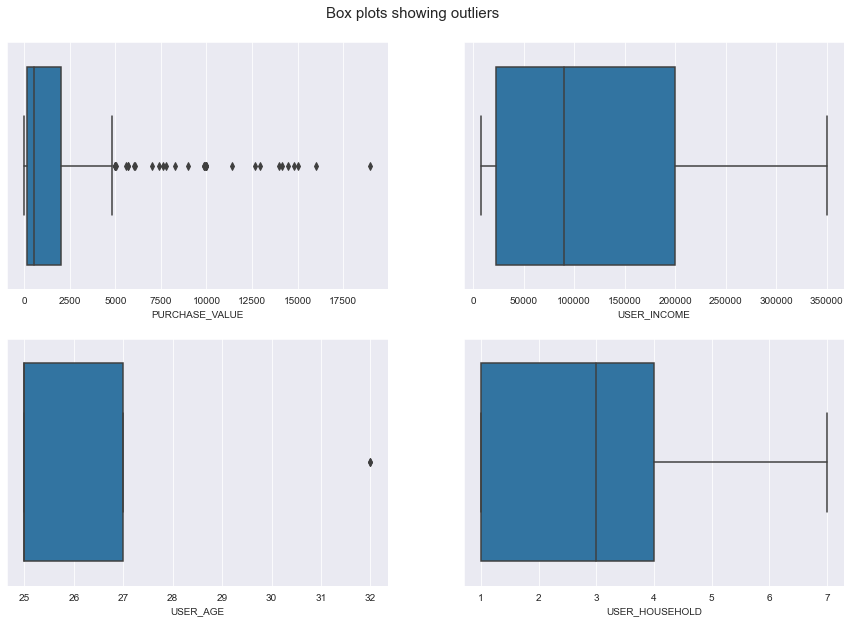

In [5]:
sns.set_style('darkgrid')
fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize = (15, 10))
fig.suptitle('Box plots showing outliers', y= 0.93, fontsize = 15)

for ax, data, name in zip(axes.flatten(), train, ['PURCHASE_VALUE','USER_INCOME','USER_AGE','USER_HOUSEHOLD']):
  sns.boxplot(train[name], ax = ax)

Let's look at a bar graph of the train data.

<BarContainer object of 373 artists>

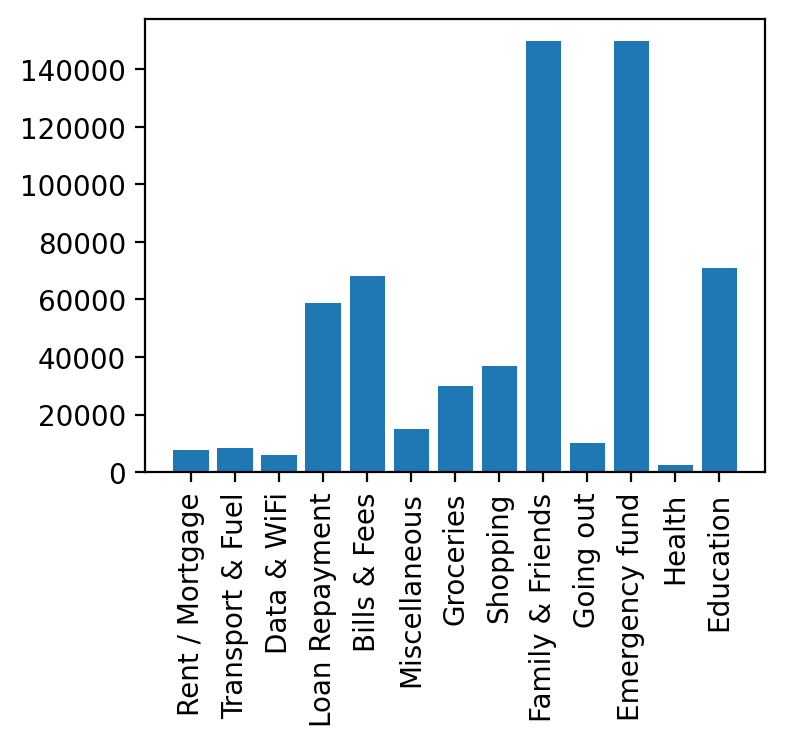

In [145]:
# Show a bar graph of the purchase_value vs the target in the train data (merchant_categorized_as)
plt.figure(dpi=200, figsize=(4,3))
plt.xticks(rotation=90)
plt.bar(data=train, x='MERCHANT_CATEGORIZED_AS', height='PURCHASE_VALUE')

It's interesting to note that more money was spent on education than bills & fees, emergency fund, rent/mortgage and loan repayment.

Also very little was spent on health and transport & fuel.

Encode the target labels to values to show a correlation matrix.

In [226]:
# Use a dictionary comprehension and zip to create a dictionary for all the categories in the train data
labels_train = train['MERCHANT_CATEGORIZED_AS'].astype('category').cat.categories.tolist()
replace_map_train = {'MERCHANT_CATEGORIZED_AS' : {k: v for k,v in zip(labels_train,list(range(1,len(labels_train)+1)))}}
print("Train data: ", replace_map_train)

Train data:  {'MERCHANT_CATEGORIZED_AS': {'Bills & Fees': 1, 'Data & WiFi': 2, 'Education': 3, 'Emergency fund': 4, 'Family & Friends': 5, 'Going out': 6, 'Groceries': 7, 'Health': 8, 'Loan Repayment': 9, 'Miscellaneous': 10, 'Rent / Mortgage': 11, 'Shopping': 12, 'Transport & Fuel': 13}}


In [224]:
# Create a copy to use for the correlation matrix (as it only accepts numerical data)
train_data_corr = train.copy()

In [227]:
# Replace the categories with the numerical equivalents from the dictionary
train_data_corr.replace(replace_map_train, inplace=True)

Correlation matrix

In [228]:
train_data_corr[train_data_corr.columns[1:]].corr()['MERCHANT_CATEGORIZED_AS'][:]

MERCHANT_CATEGORIZED_AS                  1.000000
PURCHASE_VALUE                          -0.074565
IS_PURCHASE_PAID_VIA_MPESA_SEND_MONEY   -0.086870
USER_AGE                                 0.143406
USER_HOUSEHOLD                          -0.012197
USER_INCOME                              0.041954
Name: MERCHANT_CATEGORIZED_AS, dtype: float64

We can see that not many things are correlated with MERCHANT_CATEGORIZED_AS, so it seems like we don't have enough data.

We need to drop empty rows if there are any.

In [56]:
train.dropna(how='all', inplace=True)
test.dropna(how='all', inplace=True)

## Pre-Process

By further investigation we see that the empty gender entries in the train set are all for one user: ID_R4T8Q46J in both train and test, therefore we can fill the gender with a value

###  add text features (num_of_words, length...etc). Use CountVectorizer to count the frequencies of each word and make clusters other than label encode

In [57]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import MiniBatchKMeans
def all_data_clustering_pipeline(**kwargs):

    # CHANGE TITLES TO VECTORS
    vectorizer = TfidfVectorizer(min_df=kwargs['min_df'], max_df=kwargs['max_df'],
                                 ngram_range=kwargs['ngram_range'], analyzer=kwargs['analyzer'])

    # CLUSTERING USING MiniBatchKMeans
    km = MiniBatchKMeans(n_clusters=kwargs['n_clusters'], random_state=0)

    # FIT PIPELINE
    pipe = Pipeline([('vect', vectorizer), ('kmeans', km)])
    titles = kwargs['ads_df'].apply(lambda x: np.str_(x))
    pipe.fit_transform(titles)

    # ADD MICRO_CLUSTER_ID TO DATAFRAME
    all_data['micro_cluster_id'+str(kwargs['id'])] = pipe['kmeans'].labels_
    return all_data


In [58]:
#Bining
def f(x):
    if (x > 0) and (x <= 10000):
        return 0
    elif (x > 10000) and (x <= 80000 ):
        return 1
    else :
        return 2

train['PURCHASE_VALUE_CATE'] = train['PURCHASE_VALUE'].apply(f)
test['PURCHASE_VALUE_CATE'] = test['PURCHASE_VALUE'].apply(f)


In [50]:
def trans_to_date(data):
  """ Convert columns to datetime format """
  new_data = data.copy()
  new_data['MERCHANT_CATEGORIZED_AT']= pd.to_datetime(new_data['MERCHANT_CATEGORIZED_AT'])
  new_data['PURCHASED_AT']= pd.to_datetime(new_data['PURCHASED_AT'])

  return new_data

train = trans_to_date(train)
test = trans_to_date(test)

In [51]:
def get_time_diff(data):
  """ Getting what time of day it was, noon,morning... and the diff in minutes
      from purchased_at and merechant_categorized_at"""
  new_data = data.copy()
 # new_data['merchant_cat_at_time_of_day'] = new_data['MERCHANT_CATEGORIZED_AT'].dt.hour.apply(f)
 # new_data['purchased_at_time_of_day'] = new_data['PURCHASED_AT'].dt.hour.apply(f)
  new_data['diff_minutes'] = np.absolute(new_data['PURCHASED_AT'] - new_data['MERCHANT_CATEGORIZED_AT']).astype('timedelta64[m]')
  #new_data.drop('PURCHASED_AT',1,inplace=True)
  #new_data.drop('MERCHANT_CATEGORIZED_AT',1,inplace=True)
  return new_data

test = get_time_diff(test)
train = get_time_diff(train)

### After training, date with all feature engineering, gives bad results

In [30]:
class Process :

  def LE(self,data,LE_cols = []) :
    LE = LabelEncoder()
    for le_col in LE_cols :
      data[le_col] = LE.fit_transform(data[le_col])
  
  def process(self,train,test) :
    data = pd.concat([train,test]).reset_index(drop=True)
    
    #data['date']=data['PURCHASED_AT'].apply(lambda x : x.split(' ')[0])
    #data['hour']=data['PURCHASED_AT'].apply(lambda x : x.split(' ')[1])
    # time features 
    
    #data['created_at'] = pd.to_datetime(data['date'])

    #data['PURCHASED_AT'] = pd.to_datetime(data['PURCHASED_AT'])
    #data['MERCHANT_CATEGORIZED_AT'] = pd.to_datetime(data['MERCHANT_CATEGORIZED_AT'])
    #data['diff']=abs(data['USER_INCOME']-data['PURCHASE_VALUE'])
    
    #data['same_date']=data['MERCHANT_CATEGORIZED_AT']==data['created_at']
    
    #data['diff_days']=data['diff'].astype(str).apply(lambda x : x.split(' ')[0])
    #data['diff_temp']=data['diff'].astype(str).apply(lambda x : x.split(' ')[2])
    
   # data['diff_heures']=data['diff_temp'].apply(lambda x : x.split(':')[0])
   # data['diff_min']=data['diff_temp'].apply(lambda x : x.split(':')[0])
    
    #data['user_income_2']=data['USER_INCOME']**2
    #data['user_income_sqrt']=np.sqrt(data['USER_INCOME'])
   # data['PURCHASE_VALUE_2']=data['PURCHASE_VALUE']**2
   # data['PURCHASE_VALUE_sqrt']=np.sqrt(data['PURCHASE_VALUE'])
    data['PURCHASE_VALUE_log']=np.log1p(data['PURCHASE_VALUE'])
    data['user_income_log']=np.log1p(data['PURCHASE_VALUE'])
    
    data['newf']=data['USER_INCOME']/data['USER_HOUSEHOLD']


    
   






    #data['year'] = data['created_at'].dt.year
    #data['year'] = data['year'].astype(float)
    #data['month'] = data['created_at'].dt.month
    #data['day'] = data['created_at'].dt.day
    #data['weekday'] = data['created_at'].dt.weekday
    #data['weekofyear'] = data['created_at'].dt.weekofyear

    # combination between time features
   # data['day_hour']  = data['day'].astype(str) + '-' + data['hour'].astype(str)
    #data['month_day'] = data['month'].astype(str) + '-' + data['day'].astype(str)

    # Label Encoder
   # self.LE(data,LE_cols = ['day_hour','month_day'])
    # Get our New Train,Test
    #data['SplitBy']   = data['year'].astype(int).astype(str) + '-' + data['month'].astype(str) + '-' + data['day'].astype(str)
    #data = data.sort_values('SplitBy').reset_index(drop=True)
    train = data[data['Transaction_ID'].isin(train['Transaction_ID'].values)].reset_index(drop=True)
    test = data[~data['Transaction_ID'].isin(train['Transaction_ID'].values)].reset_index(drop=True)

    return train, test

In [31]:
processor = Process()
train, test= processor.process(train,test)

In [59]:
train["USER_GENDER"] = train["USER_GENDER"].apply(lambda x: "Male" if pd.isna(x) else x)
test["USER_GENDER"] = test["USER_GENDER"].apply(lambda x: "Male" if pd.isna(x) else x)

We have various options with regards to filling in the missing values for AGE.
Let's impute these values with the median

In [60]:
def fill_missing_values(data, imputation_method='median'):
    data_copy = data.copy()
    for column in data_copy.columns:
        if data_copy[column].dtype == np.dtype('O'):
            data_copy[column] = data_copy[column].fillna(data_copy[column].mode().iloc[0])
        else:
            if imputation_method == 'median':
                data_copy[column] = data_copy[column].fillna(data_copy[column].median())
            elif imputation_method == 'mean':
                data_copy[column] = data_copy[column].fillna(data_copy[column].mean())
    return data_copy
train = fill_missing_values(train)
test = fill_missing_values(test)


### One-hot encode

Now we need to do some other changes before we can run the metrics.
One-hot encode MERCHANT_NAME so we can run metrics.

To ensure uniformity across train and test, we will merge both dataset then perform 1 hot encode

In [61]:
train["train"] = 1
test["train"] = 0
all_data = pd.concat([train, test])

all_data['len_text']=all_data['MERCHANT_NAME'].apply(len)

txt0_cluster_params = {"ads_df": all_data['MERCHANT_NAME'],"id":0,
                               "n_clusters": 30, "min_df": 0.001, "max_df": 0.99,
                               "ngram_range": (1, 1),
                               "analyzer": 'char_wb'}


all_data = all_data_clustering_pipeline(**txt0_cluster_params)

all_data = pd.get_dummies(all_data, prefix_sep="_", columns=['MERCHANT_NAME'])
all_data.drop_duplicates(subset=['Transaction_ID'])
train = all_data[all_data["train"] == 1]
test = all_data[all_data["train"] == 0]

Let's see how this affected the shapes

### Drop unnecessary columns

We can also drop unnecessary categorical columns as we're currently not interested in when the purchases were made or when they were categorized.

In [63]:
train = train.drop(['MERCHANT_CATEGORIZED_AT','PURCHASED_AT','USER_ID', 'train','Transaction_ID'], axis=1)
test = test.drop(['MERCHANT_CATEGORIZED_AT','PURCHASED_AT','USER_ID', "MERCHANT_CATEGORIZED_AS",'train'], axis=1)

### Convert Boolean to Binary

Now we convert boolean entries to binary.

In [64]:
# Based on our data set, this function converts boolean to binary entries
def create_binary_cols(content):
  if content == False:
    content = 0
  elif content == True:
    content = 1
  elif content == 'N':
    content = 0
  elif content == 'Y':
    content = 1
  elif content == 'Male':
    content = 0
  elif content == 'Female':
    content = 1
  return content

In [65]:
# Gender column convert:
train['USER_GENDER'] = train['USER_GENDER'].apply(create_binary_cols)
test['USER_GENDER'] = test['USER_GENDER'].apply(create_binary_cols)

#train['same_date'] = train['same_date'].apply(create_binary_cols)
#test['same_date'] = test['same_date'].apply(create_binary_cols)

# Is_purchase_paid_via_mpesa_send_money column convert:
train['IS_PURCHASE_PAID_VIA_MPESA_SEND_MONEY'] = train['IS_PURCHASE_PAID_VIA_MPESA_SEND_MONEY'].apply(create_binary_cols)
test['IS_PURCHASE_PAID_VIA_MPESA_SEND_MONEY'] = test['IS_PURCHASE_PAID_VIA_MPESA_SEND_MONEY'].apply(create_binary_cols)

## 3. Data preparation for machine learning

Before you train the model for prediction, you need to perform data [cleaning](https://www.dataquest.io/blog/machine-learning-preparing-data/) and [preprocessing](https://towardsdatascience.com/data-preprocessing-concepts-fa946d11c825). This is a very important step; your model will not perform well without these steps.

The first step is to separate the independent variables and target() from the training data. Then transform the target values from the object data type into numerical.


In [66]:
# Separate the features from the target in the training data
X = train.drop(["MERCHANT_CATEGORIZED_AS"], axis=1)
y = train["MERCHANT_CATEGORIZED_AS"]

In [67]:
from imblearn.over_sampling import SMOTE, ADASYN

X_resampled, y_resampled = SMOTE(k_neighbors=1).fit_resample(X, y)


## Model Building and Experiments
A portion of the training data set will be used to evaluate our models and find the best one that performs well before using it in the test dataset.


In [68]:
# # Split the training data

X_train, X_val, y_train, y_val = train_test_split(X_resampled, y_resampled, test_size=0.10, random_state=101)

In [69]:
from mlxtend.classifier import StackingClassifier
from sklearn.model_selection import KFold
from catboost import CatBoostClassifier, Pool
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import RepeatedStratifiedKFold

from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
import lightgbm as lgb
from sklearn.utils.class_weight import compute_class_weight
from sklearn.svm import SVC

kf = KFold(n_splits=5,random_state=42,shuffle=True)
for i, (train_index, valid_index) in enumerate(kf.split(X_resampled,y_resampled)):
   
    X_train, y_train = X_resampled.iloc[train_index], y_resampled.iloc[train_index]
    X_val, y_val = X_resampled.iloc[valid_index], y_resampled.iloc[valid_index]


    m =OneVsRestClassifier(StackingClassifier(
        classifiers=[
            LogisticRegression(),
    CatBoostClassifier(
         iterations=150, 
        #depth=11,
        #use_best_model =True,
        verbose =0,

        task_type="GPU",
            learning_rate=0.1,
        early_stopping_rounds= 100    
    )    ],
        use_probas=True,
        meta_classifier=LogisticRegression()
    ))





    m.fit(X_train, y_train),
    preds = m.predict_proba(X_val)
    loss+=log_loss(y_val, preds)
    print(f'log_loss: {log_loss(y_val, preds)}')
print(loss/5)

log_loss: 0.7969644262401671
log_loss: 0.651364799351064
log_loss: 0.5784153832524923
log_loss: 0.6299532084508099
log_loss: 0.75509413281664
1.4246694326621152


### 5. Making the first submission

Let’s see how the model performs on the competition test data set provided and how we rank on the competition leaderboard.

First we make predictions on the competition test data set.

In [117]:
predictions = clf.predict_proba(test.drop("Transaction_ID", axis=1))

In [75]:
# Get the predicted result for the test Data
predictions = m.predict_proba(test.drop("Transaction_ID", axis=1))
samplesubmission = pd.read_csv('SampleSubmission.csv')

sub_file = samplesubmission.copy()
sub_file= pd.DataFrame(predictions)

In [76]:
ID_column = samplesubmission["Transaction_ID"]

In [56]:
sub_file.rename(columns = {0:'Bills & Fees', 1 : 'Data & WiFi', 2: 'Education', 3: 'Emergency fund', 4: 'Family & Friends', 5: 'Going out', 6: 'Groceries', 7: 'Health', 8: 'Loan Repayment', 9: 'Miscellaneous', 10: 'Rent / Mortgage', 11: 'Shopping', 12: 'Transport & Fuel'}, inplace = True)
results = pd.concat([ID_column, sub_file], axis=1)

In [57]:
# Create the submission csv file
results.to_csv('first_submission.csv', index = False)

## More Ides
- Look at the extra dataset provided, check if it's resourceful for training
- Thorough EDA and domain knowledge sourcing
- Re-group Categorical features 
- More Feature Engineering 
- Dataset balancing - oversampling, undersampling, SMOTE...
- Ensembling of models 
- Cross-validation: Group folds, Stratified...